In [60]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import chi2_contingency
import numpy as np
from tqdm.auto import tqdm
from json import load

plt.style.use('ggplot')

### Задание 1. A/B–тестирование
1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?
Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.

1.4 Требования к ответу

При выполнении тестового задания необходимо использовать язык программирования Python. 
В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. 
Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.

1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

**groups.csv** - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
**groups_add.csv** - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных  
**active_studs.csv** - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.  
**checks.csv** - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [61]:
# группы: контрольная, экспериментальная

groups = pd.read_csv('groups.csv', sep=';')
print(groups.head(), '\n')
print('value_counts', groups.grp.value_counts(),'\n' , sep='\n')
groups.info()

     id grp
0  1489   B
1  1627   A
2  1768   B
3  1783   B
4  1794   A 

value_counts
B    59813
A    14671
Name: grp, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [62]:
# дополнительный файл с пользователями

group_add = pd.read_csv('group_add.csv', sep=',')
print(group_add.head(), '\n')
print('value_counts', group_add.grp.value_counts(), '\n', sep='\n')
group_add.info()

        id grp
0  5694584   B
1  5694830   B
2  5695057   B
3  5698872   B
4  5699067   B 

value_counts
B    70
A    22
Name: grp, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [63]:
#участники эксперимента

active_studs = pd.read_csv('active_studs.csv', sep=';')
print(active_studs.head(), '\n')
active_studs.info()

   student_id
0      581585
1     5723133
2     3276743
3     4238589
4     4475369 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [64]:
# пользователи совершившие оплату в день эксперимента

checks = pd.read_csv('checks.csv', sep=';')
print(checks.head(), '\n')
checks.info()

   student_id    rev
0        1627  990.0
1        3185  690.0
2       25973  690.0
3       26280  690.0
4      100300  990.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [65]:
# посмотрим есть ли повторные оплаы

checks.duplicated(subset=['student_id']).sum()

0

In [66]:
# проверим все ли участвовали в эксперименте - всего в дни проведения эксперимента зашло на платформу 8341, 
# а принимало участие 8328 (разбиты на группы)
# как вариант - это могут быть новые клиенты, которых еще не расплитовали

active_studs.merge(groups, how='left', left_on='student_id', right_on='id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 0 to 8340
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  8341 non-null   int64  
 1   id          8328 non-null   float64
 2   grp         8328 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 260.7+ KB


In [67]:
# проверим есть ли те кто платил, но не заходил на платформу во время эксперимента - таких 150 чел.
# как вариант - товар покупался ранее в рассрочку, и идут отсроченные платежи (автомат. списание)???

groups.merge(active_studs, how='outer', left_on='id', right_on='student_id') \
              .merge(checks, how='outer', left_on='id', right_on='student_id').drop('student_id_y', axis=1) \
              .rename(columns={"student_id_x": "active"}).query("rev.notnull()").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 1 to 74497
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      540 non-null    float64
 1   grp     540 non-null    object 
 2   active  391 non-null    float64
 3   rev     541 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.1+ KB


In [68]:
# Составим таблицу для расчета метрик.
# У нас будут id клиента, принадлежность к группе, признак акт-ти (участие в экс-те) и чек
# активных (active) просто пометим: 0 - неактивный, 1- активный

table = groups.merge(active_studs, how='left', left_on='id', right_on='student_id') \
              .merge(checks, how='left', left_on='id', right_on='student_id').drop('student_id_y', axis=1) \
              .rename(columns={"student_id_x": "active"}) \
              .fillna(0)

table['active'] = table.active.apply(lambda x: 1 if x > 0 else 0)
table

,id,grp,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0
...,...,...,...,...
74479,5692459,B,0,0.0
74480,5692572,B,0,0.0
74481,5692865,B,0,0.0
74482,5693667,B,0,0.0


In [69]:
# посчитаем все метрики за дни проведения эксперимента (active == 1), которые можно построить на основании имеющихся данных.

table.query('active == 1') \
    .groupby('grp', as_index=False).agg(count_of_ids=('id', 'count'), # кол-во пользователей в эксперименте
                                        ARPU=('rev', 'mean'), # средний чек
                                        ARPPU=('rev', lambda x: np.mean(pd.Series(x).loc[lambda x : x > 0])), # ср чек на платящего пользователя
                                        CR=('rev', lambda x: np.mean(x > 0))) # конверсия в оплату

,grp,count_of_ids,ARPU,ARPPU,CR
0,A,1535,47.439739,933.589744,0.050814
1,B,6793,57.864567,1255.827487,0.046077


In [70]:
# посмотрим на распределения платежей в разрезе групп

<AxesSubplot:xlabel='rev', ylabel='Count'>

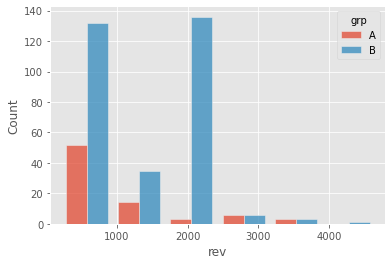

In [71]:
sns.histplot(data=table.query('rev > 0 and active == 1'), x="rev", hue="grp", multiple="dodge", shrink=.8, bins=6)

In [72]:
# в тестовой группе есть выброс в покупках на сумму около 2000р. посмотрим детальнее:

table.query('rev > 0 and grp == "B" and active == 1').rev.value_counts().head(10)

1900.0000    92
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
990.0000     17
690.0000     13
1140.0000     9
398.0000      6
590.0000      6
Name: rev, dtype: int64

Итак:  
- Кол-во участников тестовой группы значительно превосходит контрольную. Это плохая практика, но имеем то что имеем   

- Метрики - рост средних: **ARPU, ARPPU** вероятно обусловлен выбросом - покупки по 1900, в остальном распределения очень похожи. Это похоже на действие какой-то маркетинговой активности, которая подействовала только на клиентов в тестовой группе. Это довольно странно выглядит и требует дополнительной информации, но ее нет. Без нее проводить какие-либо тесты чревато критическими ошибками в выводах

   Если и проводить, то напрашивается U-критерий Манна – Уитни (данные непрерывны, смотрим на отличия средних в двух группах, есть выбросы, распределения ненормальны), но его нельзя будет использовать по причине выбросов с одинаковыми значениями (https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test). Лучшей альтернативой будет bootstrap, тк он устойчив к такого рода условиям  

   **Более того** каким-то образом оценивать различия по ARPU, ARPPU  имеет мало смысла с точки зрения того, что оценивалась новая механика оплаты. Для ее оценки более подходящим и логичным выглядит оценка конверсии в оплату **(CR)**, которая в свою очередь снизилась в тестовой группе. Тем не менее посмотрим есть ли стат. значимость в этих отличиях:

**Для проверки разницы в конверсии между группами будем использовать непараметрический критерий хи-квадрат.**

- H0 - распределение не зависит от группы.
- H1 - распределение завист от группы. 
- α = 0,05

Разобьем группы пользователей на оплативших и не оплативших. 

Составим таблицы сопряженности, и проверим - зависит ли доля совершивших платеж от принадлежности к определенной группе 

In [73]:
contingency_table = pd.crosstab(table.query('active == 1').grp, table.rev > 0)
contingency_table

rev,False,True
grp,,
A,1457,78
B,6480,313


In [74]:
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"p-value: {p}")

p-value: 0.46803677583199144


### Вывод:  
   p - value существенно выше α. Не отклоняем H0 гипотезу, стат значимой разницы в конверсии в зависимости от группы нет. А если и была бы, то скорее надо говорить о негативных влияниях новой механики  
   **Подтверждения в необходимости запускать новую механику оплаты на всех пользователей нет** 

### Задание 2. SQL  
2.1 Очень усердные ученики.

**2.1.1 Условие**

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

Необходимо **написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.**

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [75]:
# подключаемся к базе
with open("connection.json", "r") as json_file:
  connection = load(json_file)

connection_default = connection

In [76]:
# формируем запрос: группировка по id и месяцу (используем приведение типов к началу месяца). усердный ученик >= 20 заданий
query = '''
select 
    month as last_month,
    count(diligent_student) as diligent_students
from (
    select
      st_id as diligent_student,
      toStartOfMonth(timest) as month
    from
      default.peas
    group by
      st_id,
      toStartOfMonth(timest)
    having sum(correct) >= 20
    )
group by month
order by month desc
limit 1
'''
query1 = ph.read_clickhouse(query=query, connection=connection_default)

### Кол-во усердных учеников решивших 20 заданий содержится в dataframe query1.  

В задании сказано "текущий месяц". но текущий месяц 01.12.2022! поэтому сформировал запрос так, чтобы выводились данные за последнний месяц в базе. Моя логика: текущий - последний

In [77]:
query1

,last_month,diligent_students
0,2021-10-01,136


**2.2.1 Условие**

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

**Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:**

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике
- ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [78]:
# формируем соответствующий запрос
query = '''
select 
    test_grp,
    sum(money)/uniqExact(studs.st_id) as ARPU,
    sumIf(money, total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) as ARPAU,
    uniqIf(studs.st_id, money > 0)/uniqExact(studs.st_id) as CR,
    uniqIf(studs.st_id, money > 0 AND total_peas > 10)/uniqIf(studs.st_id, total_peas > 10) as CR_A,
    uniqIf(studs.st_id, money > 0 AND peas_by_math > 1 and subject = 'Math')/uniqIf(studs.st_id, peas_by_math > 1) as CR_A_math

from
  default.studs
  left join (
    select
      st_id,
      subject,
      money
    from
      default.final_project_check

  ) as checks ON studs.st_id = checks.st_id
  left join (
    select
      st_id,
      SUM(correct) as total_peas,
      SUMIf(correct, subject = 'Math') as peas_by_math
    from
      default.peas
    group by
      st_id
  ) as peas ON studs.st_id = peas.st_id
group by test_grp
'''

query2 = ph.read_clickhouse(query=query, connection=connection_default)

### Метрики:  

In [79]:
round(query2, 2)

,test_grp,ARPU,ARPAU,CR,CR_A,CR_A_math
0,control,4540.98,10393.70,0.05,0.11,0.06
1,pilot,11508.47,29739.58,0.11,0.26,0.10


### Задание 3. Python  
3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [80]:
def get_metrics(groups, group_add, active_studs, checks):
    group_add.columns = groups.columns
    groups = pd.concat([groups, group_add])
    table = groups.merge(active_studs, how='left', left_on='id', right_on='student_id') \
              .merge(checks, how='left', left_on='id', right_on='student_id').drop('student_id_y', axis=1) \
              .rename(columns={"student_id_x": "active"}) \
              .fillna(0)

    table['active'] = table.active.apply(lambda x: 1 if x > 0 else 0)

    return table.query('active == 1') \
        .groupby('grp', as_index=False) \
        .agg(count_of_ids=('id', 'count'), # кол-во пользователей в эксперименте
                     ARPU=('rev', 'mean'), # средний чек
                    ARPPU=('rev', lambda x: np.mean(pd.Series(x).loc[lambda x : x > 0])), # ср чек на платящего пользователя
                       CR=('rev', lambda x: np.mean(x > 0))) # конверсия в оплату

    

In [81]:
metrics = get_metrics(groups, group_add, active_studs, checks)
metrics

,grp,count_of_ids,ARPU,ARPPU,CR
0,A,1538,47.347204,933.589744,0.050715
1,B,6803,58.058798,1257.878992,0.046156


2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [82]:
def get_metrics_chart(metrics):
    fig, axs = plt.subplots(nrows= 1 , ncols= 3, figsize = (12, 3)) 

    axs[0].bar(metrics.grp, metrics.ARPU, color=['red', 'blue'], alpha=0.6)
    axs[0].set_title('ARPU')

    axs[1].bar(metrics.grp, metrics.ARPPU, color=['red', 'blue'], alpha=0.6)
    axs[1].set_title('ARPPU')

    axs[2].bar(metrics.grp, metrics.CR, color=['red', 'blue'], alpha=0.6)
    axs[2].set_title('CR')

    plt.show()

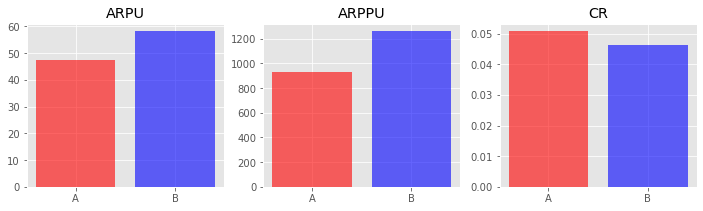

In [83]:
get_metrics_chart(metrics)